In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core')
sys.path.append('/flagellar/input/my-flg-library/')
import flg_support as fls
import importlib
import numpy as np
import flg_diagnostics
import flg_numerics
import matplotlib.pyplot as plt
import glob
import copy
import flg_preprocess
import os
importlib.reload(fls);

MainProcess
MainProcess


In [2]:
data = fls.load_all_train_data() + fls.load_all_extra_data()

C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


((300, 959, 928), dtype('uint8'), 30, 219)

In [4]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

def plot_3d_fourier_spectrum(volume_cp: cp.ndarray):
    """
    Compute and plot the 3D Fourier spectrum of a 3D uint8 CuPy array.
    
    Parameters:
    -----------
    volume_cp : cp.ndarray
        3D Cupy array with dtype uint8 representing the volume.
    """
    # Ensure input is float for FFT
    vol = volume_cp.astype(cp.float32)

    # Compute 3D FFT and shift zero-frequency component to center
    f = cp.fft.fftn(vol)
    fshift = cp.fft.fftshift(f)

    # Compute magnitude spectrum and log-scale
    magnitude = cp.log1p(cp.abs(fshift))

    # Convert to NumPy for plotting
    mag_np = cp.asnumpy(magnitude)

    # Determine center slice indices
    z_mid, y_mid, x_mid = np.array(mag_np.shape) // 2

    # Extract central slices along each axis
    slice_xy = mag_np[z_mid, :, :]
    slice_xz = mag_np[:, y_mid, :]
    slice_yz = mag_np[:, :, x_mid]

    # Plot the three orthogonal slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(slice_xy, cmap='gray')
    axes[0].set_title('XY Slice (Z center)')
    axes[0].axis('off')

    axes[1].imshow(slice_xz, cmap='gray')
    axes[1].set_title('XZ Slice (Y center)')
    axes[1].axis('off')

    axes[2].imshow(slice_yz, cmap='gray')
    axes[2].set_title('YZ Slice (X center)')
    axes[2].axis('off')

    plt.suptitle('3D Fourier Spectrum (log-scaled magnitude)')
    plt.show()

# Example usage:
# import cupy as cp
# vol = cp.random.randint(0, 256, size=(128,128,128), dtype=cp.uint8)
# plot_3d_fourier_spectrum(vol)

In [72]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

def plot_3d_fourier_quadrants(volume_cp: cp.ndarray):
    """
    Compute and plot only the non-redundant positive-frequency quadrants
    of the 3D Fourier spectrum for a 3D uint8 CuPy array.
    
    Parameters:
    -----------
    volume_cp : cp.ndarray
        3D CuPy array with dtype uint8 representing the volume.
    """
    # Convert to float and compute 3D FFT + shift
    vol = volume_cp.astype(cp.float32)
    f = cp.fft.fftn(vol)
    fshift = cp.fft.fftshift(f)
    
    # Magnitude and log-scale
    magnitude = cp.log1p(cp.abs(fshift))
    mag_np = cp.asnumpy(magnitude)
    
    # Compute midpoints
    Z, Y, X = mag_np.shape
    z_mid, y_mid, x_mid = Z//2, Y//2, X//2
    
    # Extract full central slices
    slice_xy = mag_np[z_mid, :, :]
    slice_xz = mag_np[:, y_mid, :]
    slice_yz = mag_np[:, :, x_mid]
    
    # Extract positive-frequency quadrants
    quad_xy = slice_xy[:, :]
    quad_xz = slice_xz[:, :]
    quad_yz = slice_yz[:, :]
    #quad_xy = slice_xy[y_mid:, x_mid:]
    #quad_xz = slice_xz[z_mid:, x_mid:]
    #quad_yz = slice_yz[z_mid:, y_mid:]
    
    # Plot the quadrants
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(quad_xy, cmap='gray')
    axes[0].set_title('XY Quadrant (positive fy, fx)')
    axes[0].axis('off')
    
    axes[1].imshow(quad_xz, cmap='gray')
    axes[1].set_title('XZ Quadrant (positive fz, fx)')
    axes[1].axis('off')
    
    axes[2].imshow(quad_yz, cmap='gray')
    axes[2].set_title('YZ Quadrant (positive fz, fy)')
    axes[2].axis('off')
    
    plt.suptitle('3D Fourier Spectrum Quadrants (log magnitude)')
    plt.show()

# Example usage:
# vol = cp.random.randint(0, 256, size=(128,128,128), dtype=cp.uint8)
# plot_3d_fourier_quadrants(vol)


import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

def plot_3d_fourier_as_1d(volume: np.ndarray):
    """
    Compute and plot only the non-redundant positive-frequency quadrants
    of the 3D Fourier spectrum for a 3D uint8 CuPy array.
    
    Parameters:
    -----------
    volume_cp : cp.ndarray
        3D CuPy array with dtype uint8 representing the volume.
    """
    # Convert to float and compute 3D FFT + shift
    vol = cp.array(volume.astype(np.float32))
    f = cp.fft.fftn(vol)
    del vol
    fshift = cp.fft.fftshift(f)
    del f
    
    # Magnitude and log-scale
    mag_np = np.abs(cp.asnumpy(fshift))
    del fshift
    
    # Compute midpoints
    Z, Y, X = mag_np.shape
    z_mid, y_mid, x_mid = Z//2, Y//2, X//2

    mag_np = mag_np[z_mid:,y_mid:,x_mid:]
    sizes = [np.arange(xx) for xx in mag_np.shape]
    mag_vel = np.sqrt(sizes[0][:,None,None]**2 + sizes[1][None,:,None]**2 + sizes[2][None,None,:]**2)
    inds = np.argsort(mag_vel.ravel())
    mag_sorted = mag_np.ravel()[inds]
    mag_sum = np.cumsum(mag_sorted)
    mag_sum = (mag_sum)/np.max(mag_sum)

    plt.semilogy(mag_vel.ravel()[inds], mag_sum)
    #plt.scatter(mag_vel.flatten(), mag_np.flatten())

    #print(mag_np.shape, mag_vel.shape)

def plot_3d_power_spectrum_1d(volume: np.ndarray):
    """
    volume: 3D uint8 or float array
    """
    # 1) Cast to float32 and optionally window:
    vol = volume.astype(np.float32)
    # Example window (uncomment to use):
    # wx = np.hanning(vol.shape[2])[None,None,:]
    # wy = np.hanning(vol.shape[1])[None,:,None]
    # wz = np.hanning(vol.shape[0])[:,None,None]
    # vol *= wz * wy * wx

    # 2) FFT + shift
    F = np.fft.fftn(vol)
    F = np.fft.fftshift(F)
    # 3) Power spectrum
    P = np.abs(F)**2
    del F, vol

    # 4) Build frequency grids (in pixel^-1)
    Nz, Ny, Nx = P.shape
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d=1.0))
    fy = np.fft.fftshift(np.fft.fftfreq(Ny, d=1.0))
    fz = np.fft.fftshift(np.fft.fftfreq(Nz, d=1.0))
    FZ, FY, FX = np.meshgrid(fz, fy, fx, indexing='ij')
    fr = np.sqrt(FX**2 + FY**2 + FZ**2)  # radial frequency

    # 5) Flatten & sort by freq
    fr_flat = fr.ravel()
    P_flat  = P.ravel()
    idx = np.argsort(fr_flat)
    fr_sorted = fr_flat[idx]
    P_sorted  = P_flat[idx]

    # 6) Radial binning into Nbins
    Nbins = min(200, Nx//2)
    bins = np.linspace(0, fr_sorted.max(), Nbins+1)
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    P_radial = np.zeros(Nbins, dtype=np.float64)
    for i in range(Nbins):
        mask = (fr_sorted >= bins[i]) & (fr_sorted < bins[i+1])
        if np.any(mask):
            P_radial[i] = P_sorted[mask].mean()
        else:
            P_radial[i] = np.nan

    # 7) Plot
    plt.figure(figsize=(6,4))
    plt.plot(bin_centers, P_radial, '-o', markersize=4)
    plt.xlabel('Spatial frequency (pixel⁻¹)')
    plt.ylabel('Power (|F|²) [arb. units]')
    plt.title('Radially averaged 3D power spectrum')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



#@fls.profile_each_line
def plot_3d_cumulative_spectrum_1d(volume: np.ndarray, window=False, ax_scale=1.0, cutoff1=0.01, cutoff2=0.1):
    """
    Compute and plot the cumulative radially averaged 3D power spectrum.
    
    Parameters:
    -----------
    volume : np.ndarray
        3D array (uint8 or float) of the tomogram.
    window : bool
        Whether to apply a 3D Hanning window to reduce edge artifacts.
    Nbins : int
        Number of radial bins.
    """
    # 1) Cast to float and optional window
    vol = volume.astype(np.float32)
    if window:
        wz = np.hanning(vol.shape[0])[:, None, None]
        wy = np.hanning(vol.shape[1])[None, :, None]
        wx = np.hanning(vol.shape[2])[None, None, :]
        vol *= wz * wy * wx

    # 2) FFT + shift
    F = np.fft.fftn(vol)
    F = np.fft.fftshift(F)

    # 3) Power spectrum
    P = np.abs(F)**2
    del F, vol

    # 4) Frequency grids (pixel^-1)
    Nz, Ny, Nx = P.shape
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d=1.0))
    fy = np.fft.fftshift(np.fft.fftfreq(Ny, d=1.0))
    fz = np.fft.fftshift(np.fft.fftfreq(Nz, d=1.0))
    FZ, FY, FX = np.meshgrid(fz, fy, fx, indexing='ij')
    fr = np.sqrt(FX**2 + FY**2 + FZ**2).ravel()

    # 5) Flatten power and sort by frequency
    P_flat = P.ravel()
    to_use = np.logical_and(fr<cutoff2,fr>cutoff1)
    fr = fr.ravel()[to_use]
    P_flat=P_flat[to_use]
    
    idx = np.argsort(fr)
    fr_sorted = fr[idx]
    P_sorted = P_flat[idx]

    # 6) Cumulative sum and normalize
    cumulative = np.cumsum(P_sorted)
    cumulative /= cumulative[-1]

    # 7) Plot cumulative spectrum
    #plt.figure(figsize=(6, 4))
    plt.plot(ax_scale*fr_sorted, cumulative, linewidth=1)
    plt.xlabel('Spatial frequency (pixel⁻¹)')
    plt.ylabel('Cumulative power (normalized)')
    plt.title('Cumulative 3D Power Spectrum')
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

# Example usage:
# vol = cp.random.randint(0, 256, size=(128,128,128), dtype=cp.uint8)
# plot_3d_fourier_quadrants(vol)
fls.profiling=True

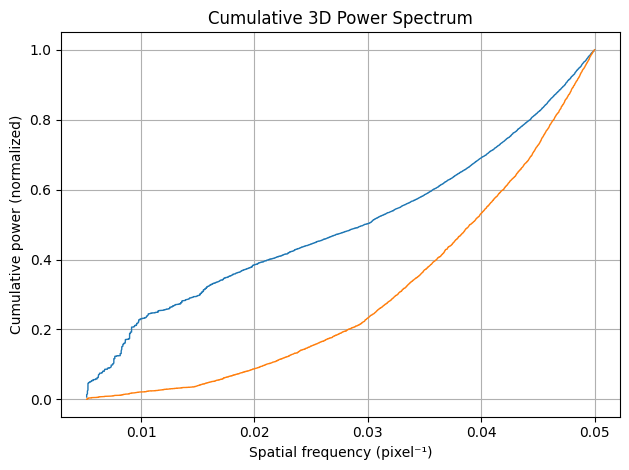

In [76]:
plt.figure()
#plot_3d_cumulative_spectrum_1d(d.data)
plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=1/2, cutoff1=0.01, cutoff2=0.1)
plot_3d_cumulative_spectrum_1d(d.data[::4,::4,::4], ax_scale=1/4, cutoff1=0.01*2, cutoff2=0.1*2)


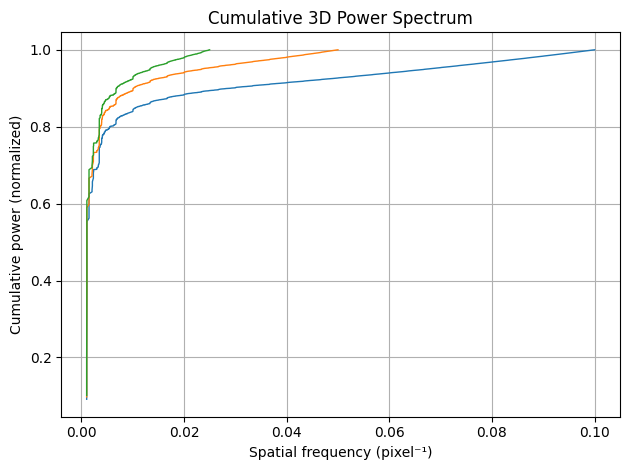

In [53]:
plt.figure()
#plot_3d_cumulative_spectrum_1d(d.data)
plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=1/2)
plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2][:100,:100,:100], ax_scale=1/4)


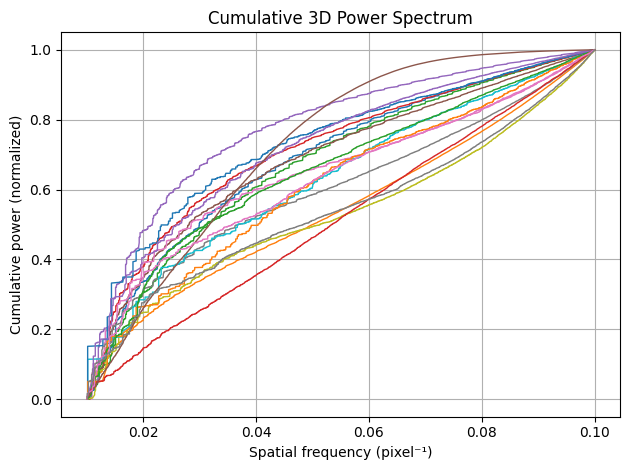

In [79]:
for d in data[::100]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor()
    prep.scale_percentile = True
    prep.return_uint8 = True
    
    prep.load_and_preprocess(d)
    vn = d.voxel_spacing/15
    plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=vn, cutoff1=0.01/vn, cutoff2=0.1/vn)

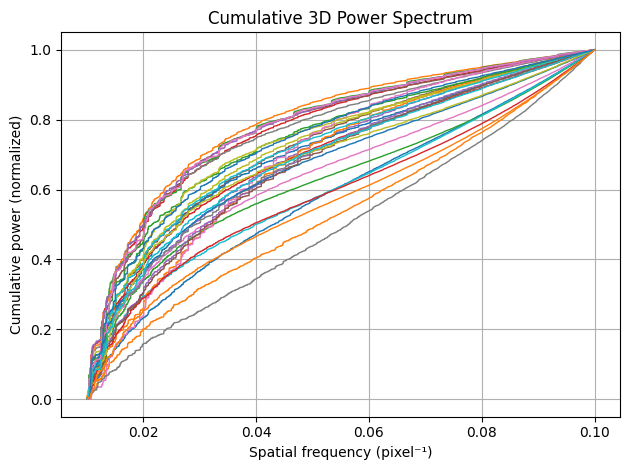

In [90]:
for d in fls.load_all_train_data()[::20]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor()
    prep.scale_percentile = True
    prep.return_uint8 = True
    
    prep.load_and_preprocess(d)
    vn = 1
    plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=vn, cutoff1=0.01/vn, cutoff2=0.1/vn)

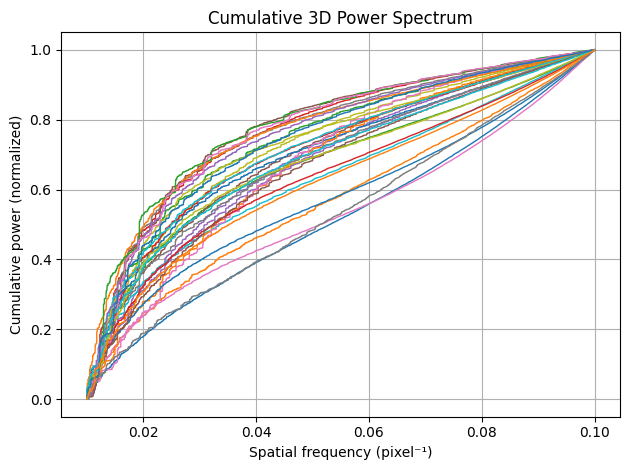

In [ ]:
for d in fls.load_all_train_data()[::20]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor()
    prep.scale_percentile = True
    prep.return_uint8 = True
    
    prep.load_and_preprocess(d)
    vn = 1/(d.voxel_spacing/15)
    plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=vn, cutoff1=0.01/vn, cutoff2=0.1/vn)

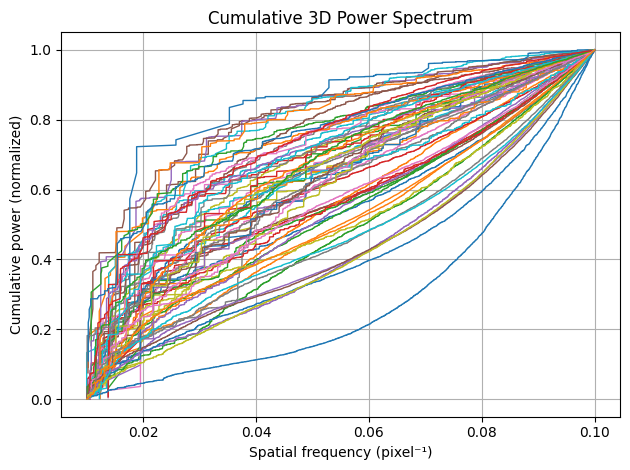

In [89]:
for d in fls.load_all_extra_data()[::20]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor()
    prep.scale_percentile = True
    prep.return_uint8 = True
    
    prep.load_and_preprocess(d)
    vn = 1/(d.voxel_spacing/15)
    plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=vn, cutoff1=0.01/vn, cutoff2=0.1/vn)

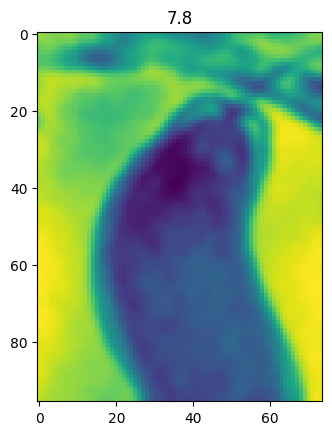

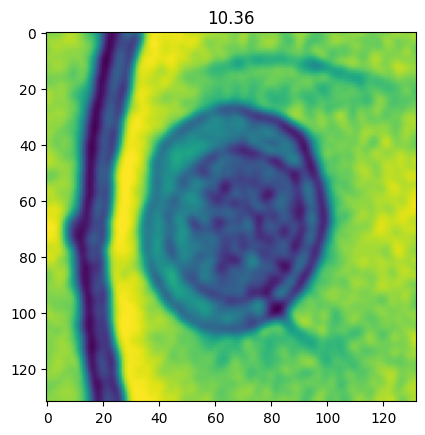

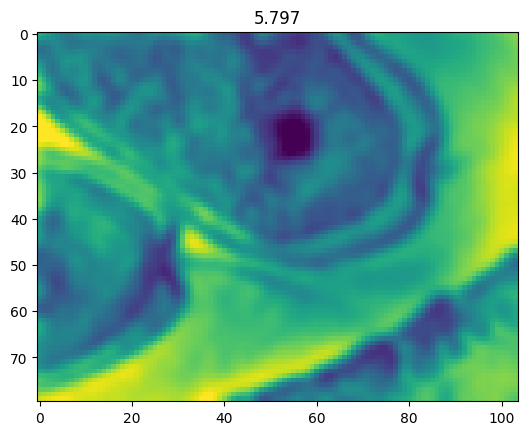

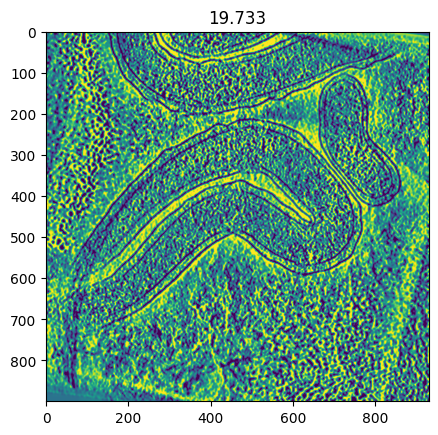

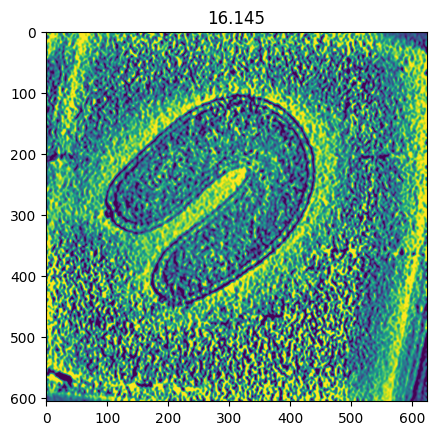

In [ ]:
for d in data[1500::100]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor2()    
    prep.load_and_preprocess(d)

    plt.figure()
    plt.imshow(d.data[d.data.shape[0]//2,:,:])
    plt.title(d.voxel_spacing)

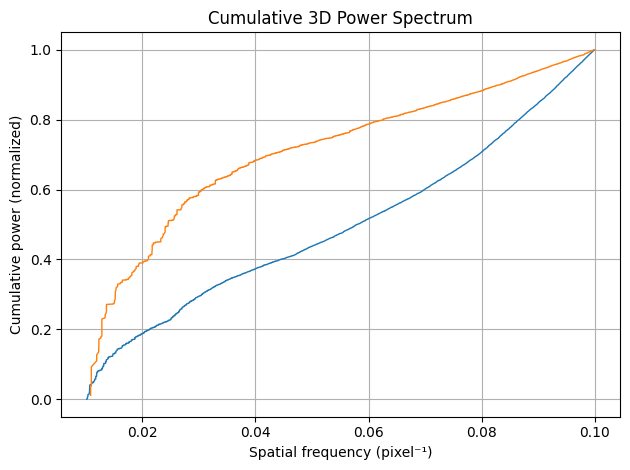

In [86]:
for d in data[1800::100]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor()
    prep.scale_percentile = True
    prep.return_uint8 = True
    
    prep.load_and_preprocess(d)
    vn = 1/(d.voxel_spacing/15)
    plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=vn, cutoff1=0.01/vn, cutoff2=0.1/vn)

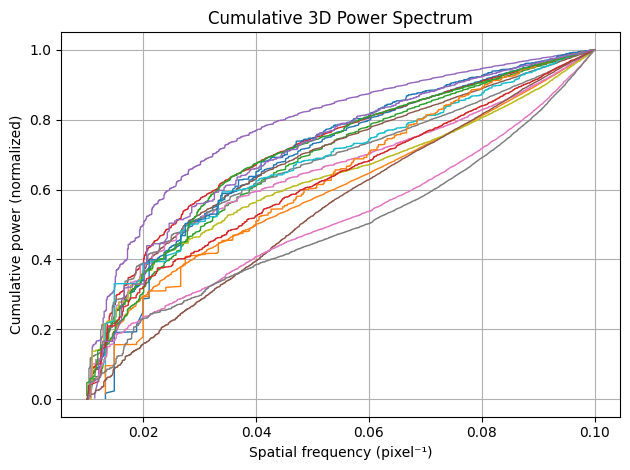

In [ ]:
for d in data[::100]:
    if np.prod(d.data_shape)>966985600:
        continue
    prep = flg_preprocess.Preprocessor()
    prep.scale_percentile = True
    prep.return_uint8 = True
    
    prep.load_and_preprocess(d)
    vn = 1
    plot_3d_cumulative_spectrum_1d(d.data[::2,::2,::2], ax_scale=vn, cutoff1=0.01/vn, cutoff2=0.1/vn)

In [66]:
len(data[:10]+data[-10:])

20

(928,)


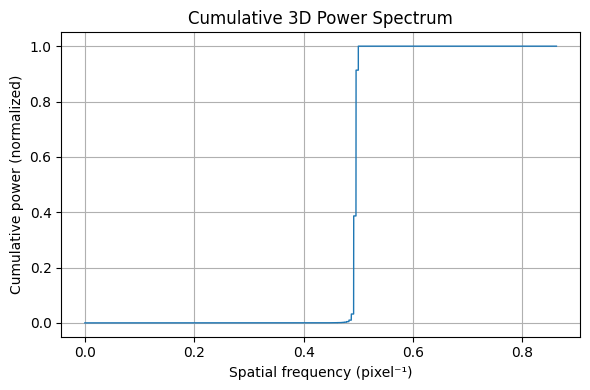

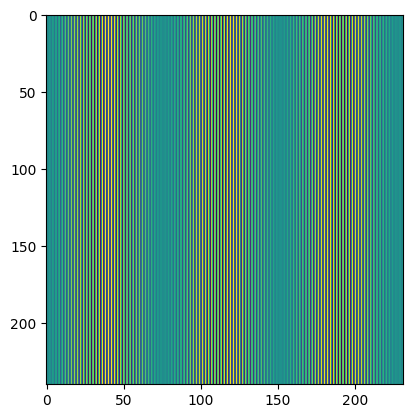

In [ ]:
#import scipy
#zoomed = copy.deepcopy(d.data[::20,::20,::20])
#print(zoomed.shape)
print( (np.sin(5*np.arange(d.data.shape[2])/2/np.pi)).shape)
XX = np.tile(np.sin(5*np.arange(d.data.shape[2])/2/np.pi), (d.data.shape[0],d.data.shape[1],1))
#print(XX.shape)
XX = XX[::4,::4,::4]
plot_3d_cumulative_spectrum_1d(XX)
plt.figure();plt.imshow(XX[0])

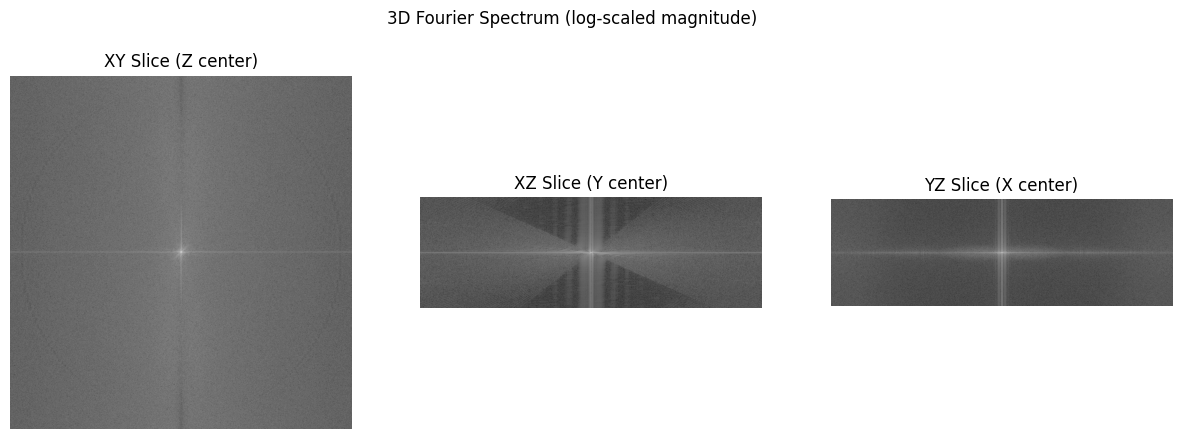

In [ ]:
plot_3d_fourier_spectrum(cp.array(d.data))

NameError: name 'plot_3d_fourier_as_1d' is not defined